In [1]:
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['image.cmap'] = 'viridis'

import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

import numpy as np

import seaborn as sns
# sns.set()
sns.set_style("white")


plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 18


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import pandas as pd
from IPython.display import display


In [3]:
!ls xsum/fact_check_xsum

formatted-test.txt   rouge_score.json	  test.ckp8.ent_beam4.hypo0
quagen_score_2.json  span_coco_score.txt  token_coco_score.txt


In [4]:
path = "."
datasets = ["xsum", "cnndm"]
approaches = {
    "cliff": [
        "cliff_xsum_all",
        "cliff_xsum_cnndm_all",
        "cliff_xsum_all_but_maskent",
        "cliff_xsum_swapent_syslowcon",
        "cliff_xsum_cnndm_swapent_syslowcon",
    ],
    "fact_check": [
        "fact_check_xsum",
        "fact_check_xsum_cnndm",
        "fact_check_xsum_cnndm_xsum",
        "fact_check_xsum_cnndm_xsum_cnndm",
    ],
    "mixed": [
        "fc_plus_all_xsum",
        "fc_plus_all_xsum_cnndm",
        "fc_plus_swapent_syslowcon_xsum",
        "fc_plus_swapent_syslowcon_xsum_cnndm",
    ]
}

metrics = [
    ("quagen", "quagen_score_2.json"), 
    ("coco_span", "span_coco_score.txt"), 
    ("coco_token", "token_coco_score.txt"), 
    ("rouge", "rouge_score.json")
]



In [219]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''), index=data.index, columns=data.columns)

In [220]:
def process_metric_file(name, file_path):
    with open(file_path) as f:
        if name == "quagen":
            j = json.load(f)
            fscore = np.mean([d["fscore"] for d in j])
            precision = np.mean([d["precision"] for d in j])
            recall = np.mean([d["recall"] for d in j])
            return {
                "fscore": fscore,
                "precision": precision,              
                "recall": recall
            }
        elif name == "rouge":
            j = json.load(f)
            fscore = np.mean([d["rouge-1"]["f"] for d in j])
            precision = np.mean([d["rouge-2"]["f"] for d in j])
            recall = np.mean([d["rouge-l"]["f"] for d in j])
            return {
                "1": fscore,
                "2": precision,              
                "l": recall
            }
        else:
            j = f.readlines()
            score = np.mean(list(map(float, j)))
            return {
                "score": score
            }
        

In [221]:
res = {}
for dataset in datasets:
    for approach_name, sub_apps in approaches.items():
        for app in sub_apps:
            curr_res = {}
            for metric_name, metric_file in metrics:
                path = os.path.join(dataset, app, metric_file)
                if os.path.exists(path):
                    metric_res = process_metric_file(metric_name, path)
                    for k, v in metric_res.items():
                        curr_res[f"{metric_name}_{k}"] = v

#                 else:
#                     curr_res.append({None})
            res[f"{dataset}_{app}"] = curr_res

In [222]:
columns = ['quagen_fscore', 'quagen_precision', 'quagen_recall', 'coco_span_score', 'coco_token_score', 'rouge_1', 'rouge_2', 'rouge_l']


In [223]:
names = []
metrics = []
for name, scores in res.items():
    names.append(name)
    metrics.append([scores.get(s, None) for s in columns])
metrics = np.array(metrics)

In [224]:
dataset_map = {
    "cnndm": "CNN/DailyMail",
    "xsum": "XSUM"
}

methods_map = {
    "xsum_all": "XSUM all",
    "xsum_cnndm_all": "XSUM+CNNDM all",
    "xsum_all_but_maskent": "XSUM all/maskent",
    "xsum_swapent_syslowcon": "XSUM original",
    "xsum_cnndm_swapent_syslowcon": "XSUM+CNNDM  original",
    "xsum": "XSUM",
    "xsum_cnndm": "XSUM+CNNDM",
    "xsum_cnndm_xsum": "Fact XSUM",
    "xsum_cnndm_xsum_cnndm": "Fact XSUM+CNNDM",
    "all_xsum": "XSUM all",
    "all_xsum_cnndm": "XSUM+CNNDM all",
    "swapent_syslowcon_xsum": "XSUM original",
    "swapent_syslowcon_xsum_cnndm": "XSUM+CNNDM  original",
    
}

paper_map = {
    "fact_check": "QUALS",
    "cliff": "CLIFF",
    "fc_plus": "QUALS + CLIFF"
}

metric_map = {
    'quagen_fscore': "Quest Eval Fscore", 
    'quagen_precision': "Quest Eval Precision", 
    'quagen_recall': "Quest Eval Recall", 
    'coco_span_score': "CoCo Span score", 
    'coco_token_score': "CoCo Token score", 
    'rouge_1': "ROUGE-1", 
    'rouge_2': "ROUGE-2", 
    'rouge_l': "ROUGE-L"
}


In [225]:
# dtst, papers, ns = [], [], []
ind = []
for name, scores in res.items():
    info = name.split("_")
#     dtst.append(info[0])
    if info[1] == "cliff":
        paper = info[1]
        name = "_".join(info[2:])
    else:
        paper = "_".join(info[1:3])
        name = "_".join(info[3:])
#     papers.append(paper)
#     ns.append(name)
    ind.append((dataset_map[info[0]], paper_map[paper], methods_map[name]))


In [226]:
index = pd.MultiIndex.from_tuples(ind, names=["dataset", "paper", "method"])

In [227]:
df = pd.DataFrame(metrics, columns=[metric_map[col] for col in columns], index=index)
df = df.astype(float)

In [228]:
# df = pd.DataFrame(metrics, columns=columns)
# df = df.astype(float)
# df = df.set_index(pd.Index(names))

In [234]:
dataset = "CNN/DailyMail"
df.loc[dataset, "QUALS", "Fact XSUM+CNNDM"]

Quest Eval Fscore       0.382
Quest Eval Precision    0.515
Quest Eval Recall       0.248
CoCo Span score         0.610
CoCo Token score        0.590
ROUGE-1                 0.394
ROUGE-2                 0.171
ROUGE-L                 0.373
Name: (CNN/DailyMail, QUALS, Fact XSUM+CNNDM), dtype: float64

In [230]:
df.corr()

,Quest Eval Fscore,Quest Eval Precision,Quest Eval Recall,CoCo Span score,CoCo Token score,ROUGE-1,ROUGE-2,ROUGE-L
Quest Eval Fscore,1.000,0.992,0.963,0.870,0.860,0.725,0.715,0.715
Quest Eval Precision,0.992,1.000,0.922,0.851,0.840,0.680,0.669,0.668
Quest Eval Recall,0.963,0.922,1.000,0.869,0.861,0.775,0.762,0.770
CoCo Span score,0.870,0.851,0.869,1.000,0.998,0.412,0.386,0.395
CoCo Token score,0.860,0.840,0.861,0.998,1.000,0.389,0.365,0.371
ROUGE-1,0.725,0.680,0.775,0.412,0.389,1.000,0.976,0.983
ROUGE-2,0.715,0.669,0.762,0.386,0.365,0.976,1.000,0.988
ROUGE-L,0.715,0.668,0.770,0.395,0.371,0.983,0.988,1.000


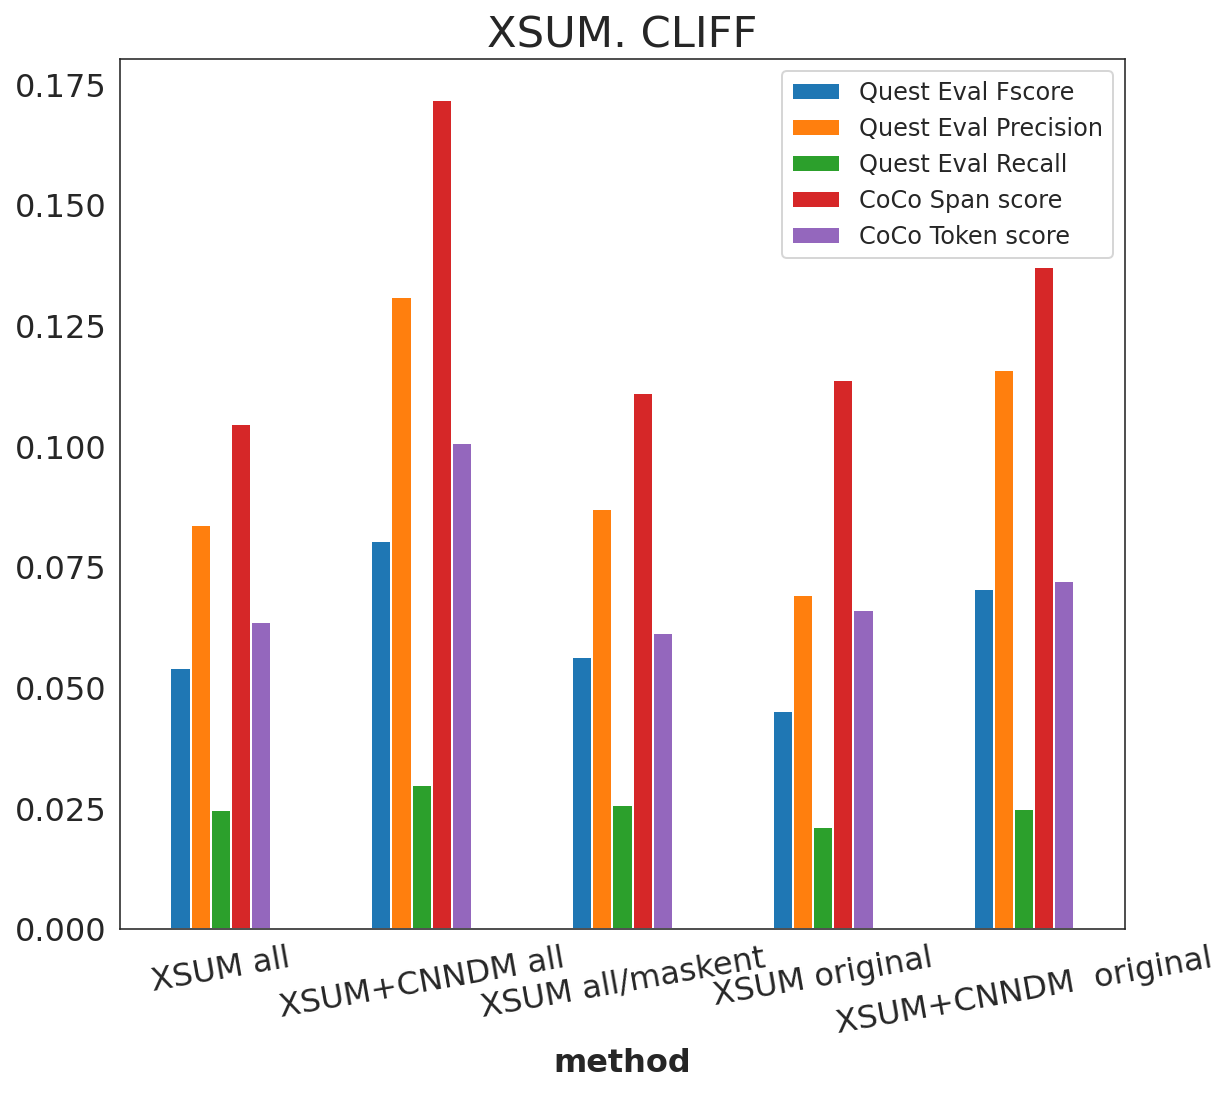

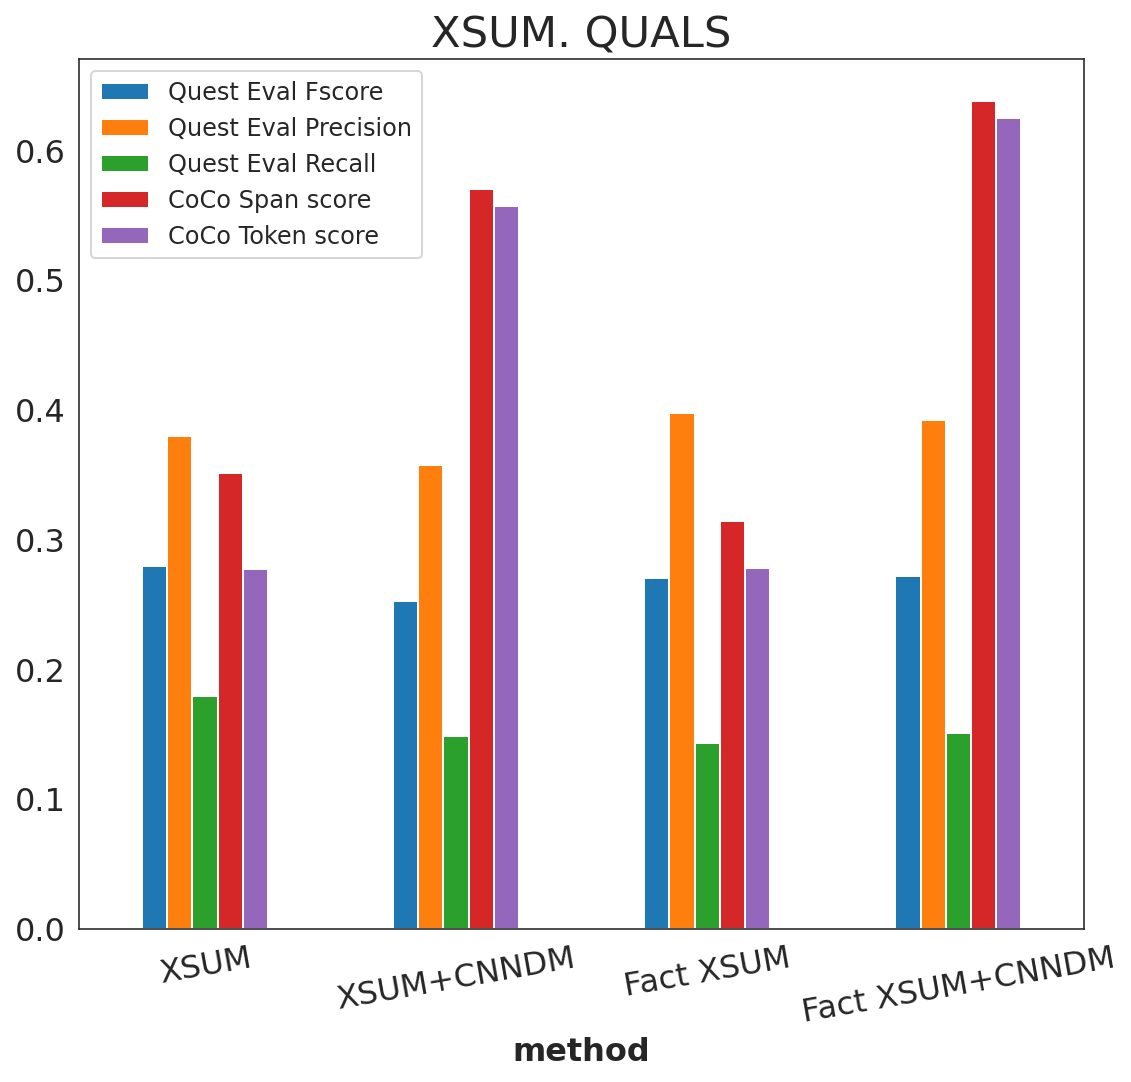

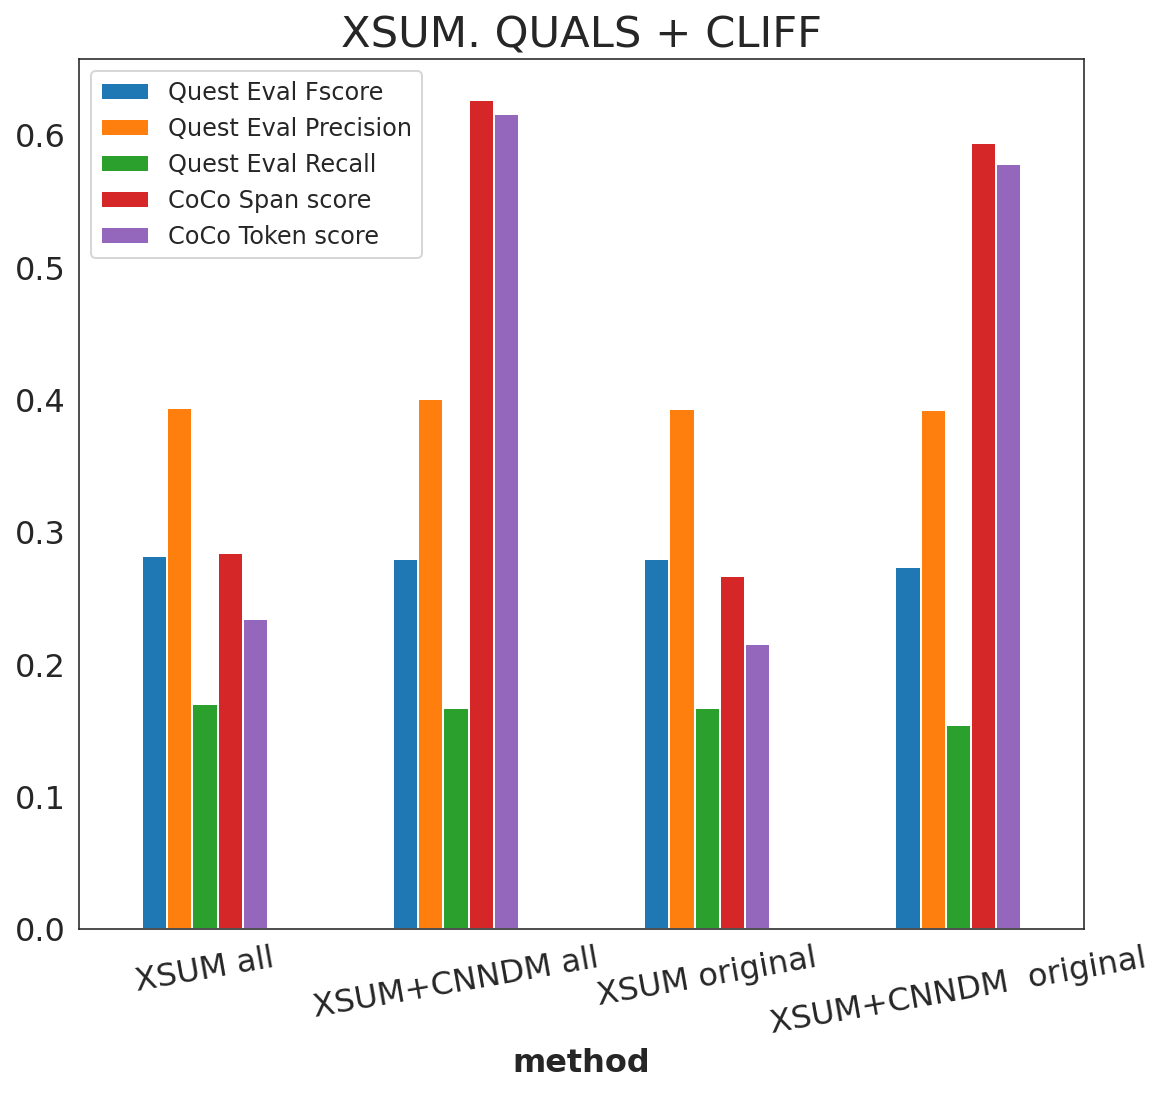

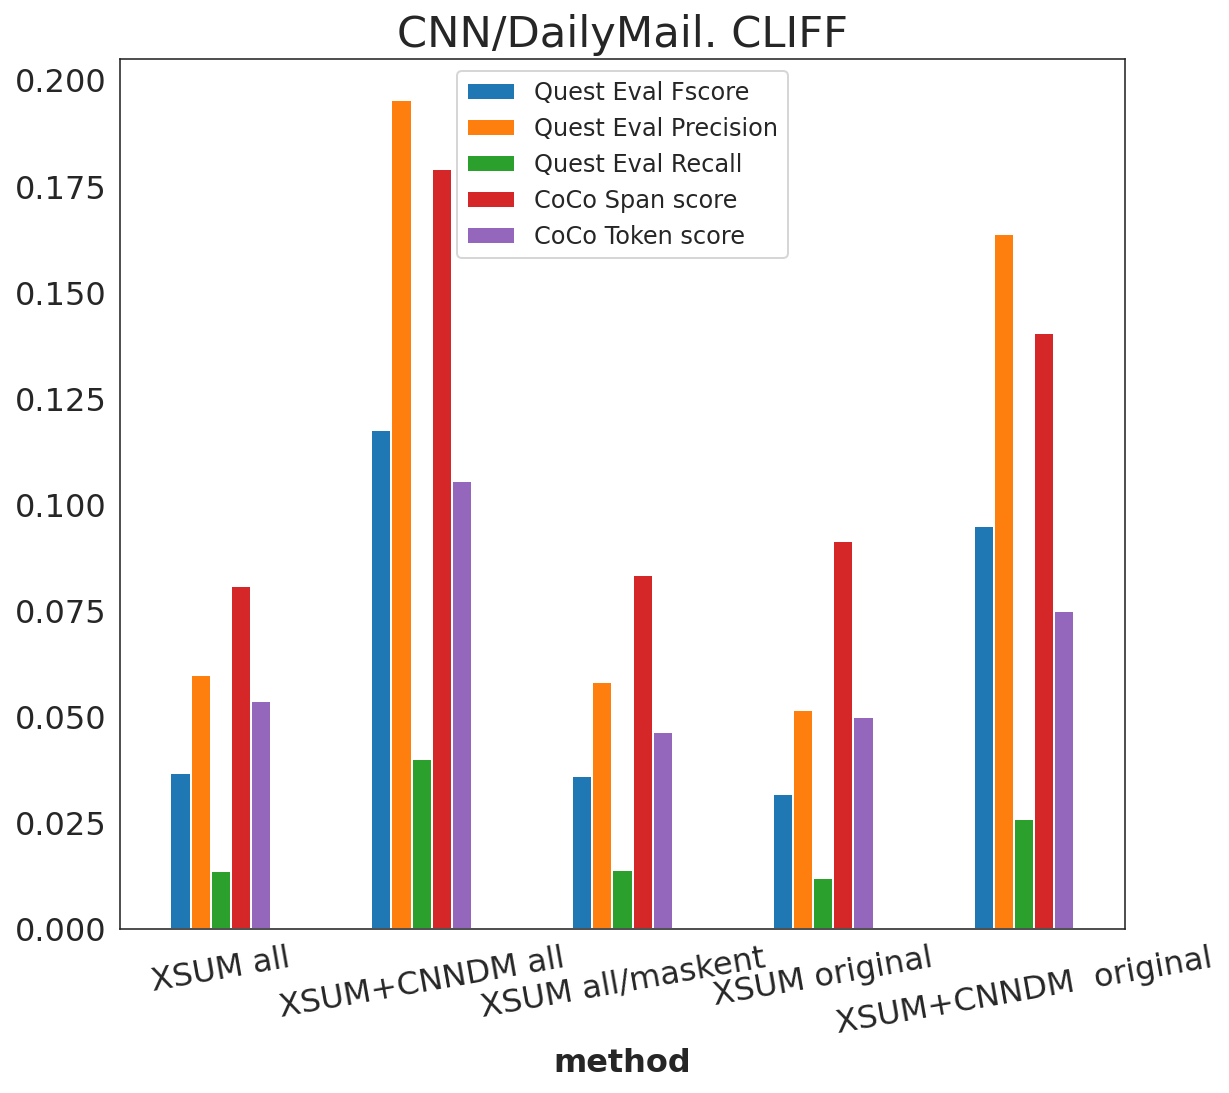

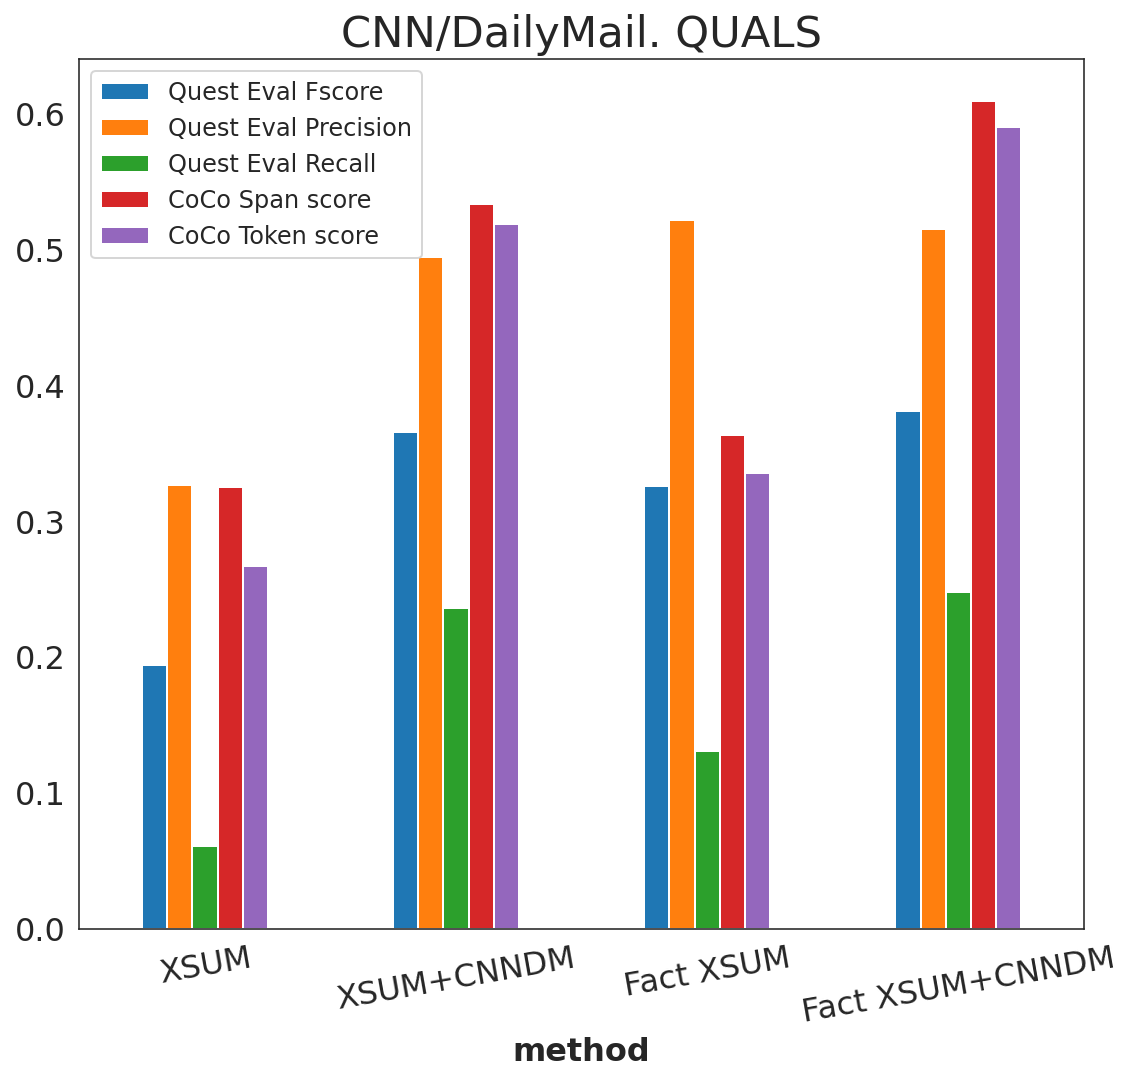

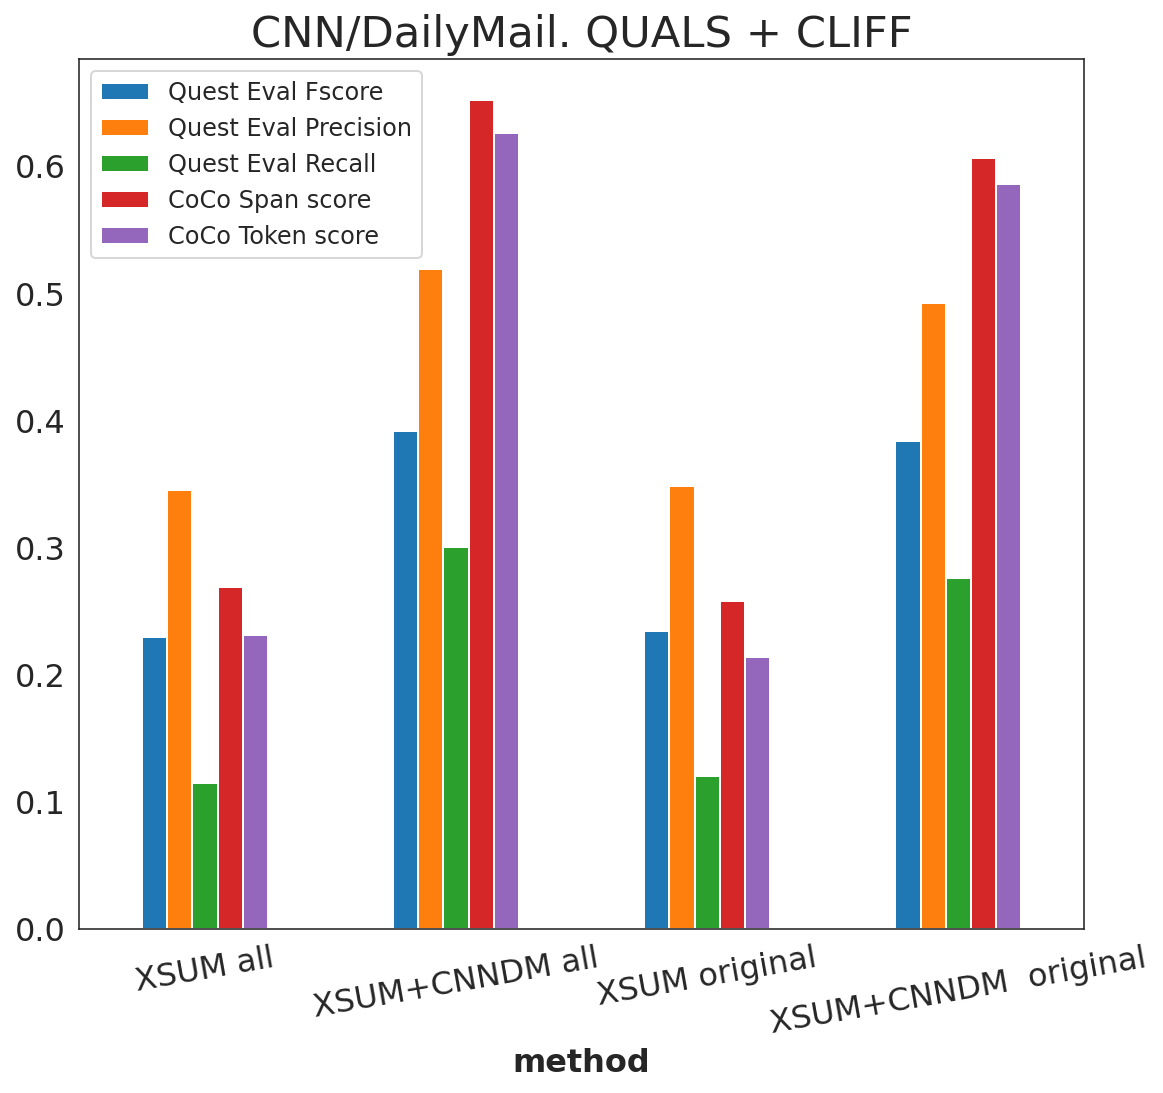

In [231]:
datsets = ["xsum", "cnndm"]
methods = ["cliff", "fact_check", "fc_plus"]

for dataset in datasets:
    dataset = dataset_map[dataset]
    for method in methods:
        method = paper_map[method]
        ax = plt.axes()
        ax.set_title(f"{dataset}. {method}")
        ndf = df.loc[dataset, method].reset_index()
        ndf.plot(x="method", y=df.columns.values[:-3], kind="bar",figsize=(9,8), ax=ax)
        ax.tick_params(axis='x', labelrotation = 10)
        plt.show()

In [232]:
pd.set_option("display.precision", 3)

In [233]:
dfs = []
for dataset, new_df in df.groupby(level=0):
    for paper, newer_df in new_df.groupby(level=1):
#         dfs.append(newer_df.style.apply(highlight_max))
        display(newer_df.style.apply(highlight_max))

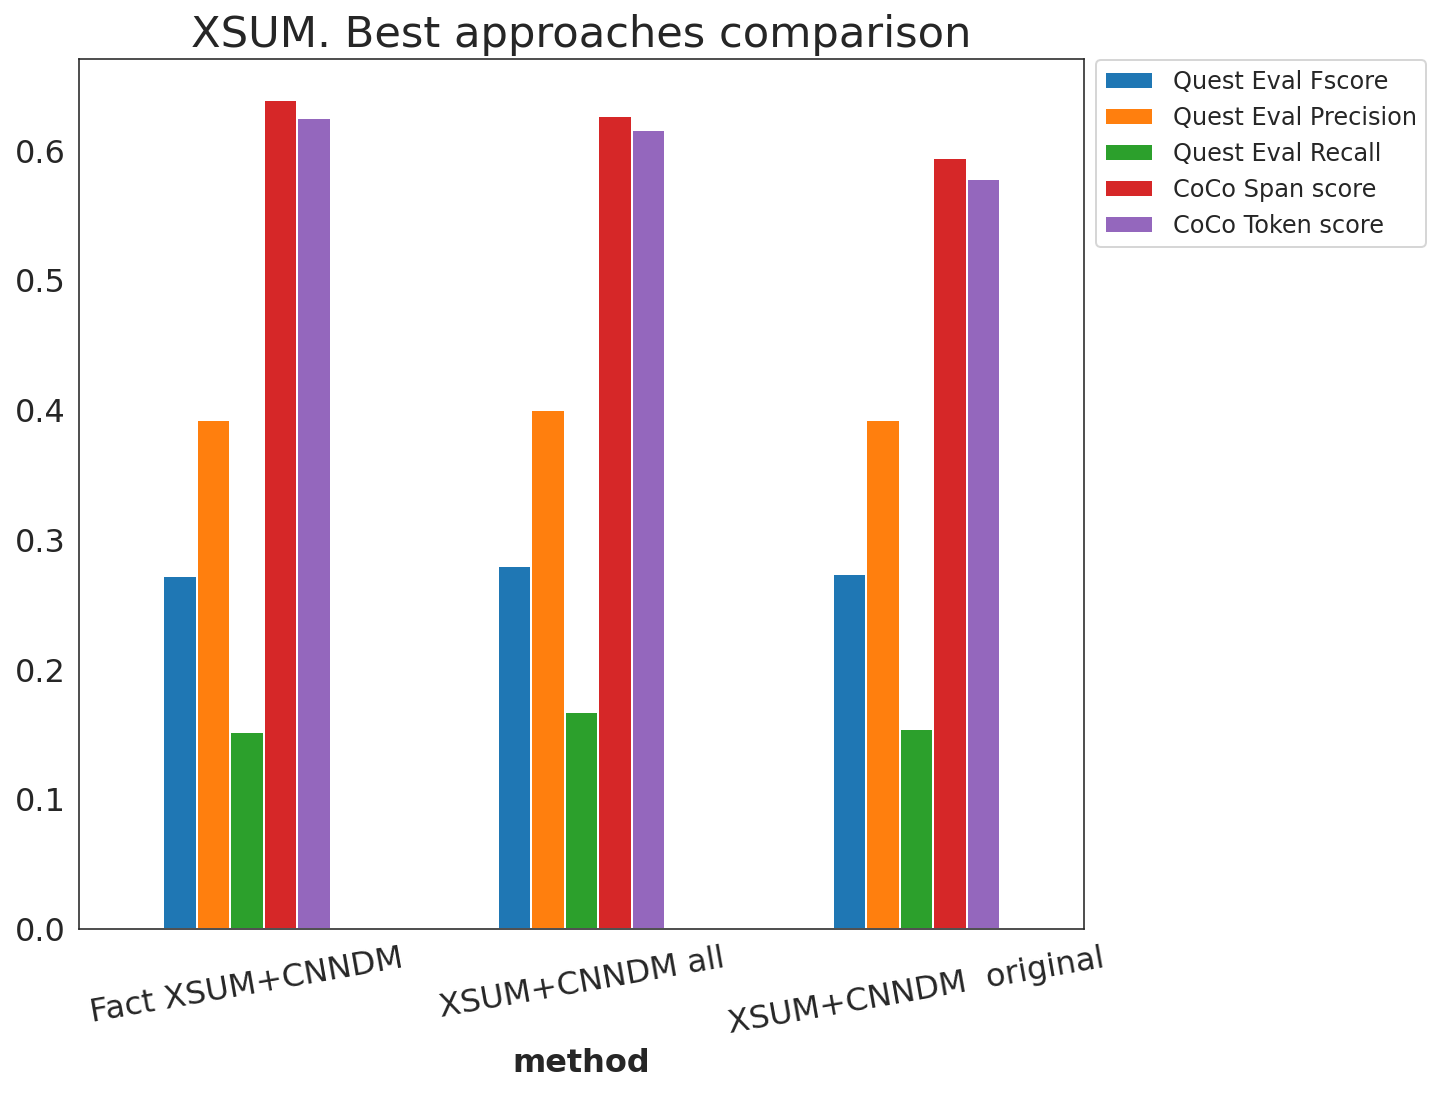

In [265]:
ax = plt.axes()
ax.set_title(f"XSUM. Best approaches comparison")
ndf = df.iloc[[8, 10, 12]].reset_index()
ndf.plot(x="method", y=df.columns.values[:-3], kind="bar",figsize=(9,8), ax=ax)
ax.tick_params(axis='x', labelrotation = 10)
ax.legend(loc="lower left", bbox_to_anchor = (1.0, 0.77))

In [285]:
df.iloc[[8, 10, 12]].droplevel(1, axis=0)

Quest Eval Fscore  Quest Eval Precision  \
dataset method                                                          
XSUM    Fact XSUM+CNNDM                   0.272                 0.392   
        XSUM+CNNDM all                    0.279                 0.400   
        XSUM+CNNDM  original              0.273                 0.392   

                              Quest Eval Recall  CoCo Span score  \
dataset method                                                     
XSUM    Fact XSUM+CNNDM                   0.151            0.638   
        XSUM+CNNDM all                    0.167            0.626   
        XSUM+CNNDM  original              0.154            0.594   

                              CoCo Token score  ROUGE-1  ROUGE-2  ROUGE-L  
dataset method                                                             
XSUM    Fact XSUM+CNNDM                  0.625    0.212    0.028    0.186  
        XSUM+CNNDM all                   0.616    0.273    0.027    0.189  
        XSUM+CNNDM  original             0.578    0.217    0.031    0.190

In [286]:
df.iloc[[21, 23, 25]].droplevel(1, axis=0)

Quest Eval Fscore  Quest Eval Precision  \
dataset       method                                                          
CNN/DailyMail Fact XSUM+CNNDM                   0.382                 0.515   
              XSUM+CNNDM all                    0.391                 0.519   
              XSUM+CNNDM  original              0.384                 0.493   

                                    Quest Eval Recall  CoCo Span score  \
dataset       method                                                     
CNN/DailyMail Fact XSUM+CNNDM                   0.248            0.610   
              XSUM+CNNDM all                    0.300            0.652   
              XSUM+CNNDM  original              0.276            0.606   

                                    CoCo Token score  ROUGE-1  ROUGE-2  \
dataset       method                                                     
CNN/DailyMail Fact XSUM+CNNDM                  0.590    0.394    0.171   
              XSUM+CNNDM all                   0.626    0.410    0.147   
              XSUM+CNNDM  original             0.586    0.408    0.176   

                                    ROUGE-L  
dataset       method                         
CNN/DailyMail Fact XSUM+CNNDM         0.373  
              XSUM+CNNDM all          0.368  
              XSUM+CNNDM  original    0.386

In [279]:
df.iloc[[8, 10, 12, 21, 23, 25]]

Quest Eval Fscore  \
dataset       paper         method                                    
XSUM          QUALS         Fact XSUM+CNNDM                   0.272   
              QUALS + CLIFF XSUM+CNNDM all                    0.279   
                            XSUM+CNNDM  original              0.273   
CNN/DailyMail QUALS         Fact XSUM+CNNDM                   0.382   
              QUALS + CLIFF XSUM+CNNDM all                    0.391   
                            XSUM+CNNDM  original              0.384   

                                                  Quest Eval Precision  \
dataset       paper         method                                       
XSUM          QUALS         Fact XSUM+CNNDM                      0.392   
              QUALS + CLIFF XSUM+CNNDM all                       0.400   
                            XSUM+CNNDM  original                 0.392   
CNN/DailyMail QUALS         Fact XSUM+CNNDM                      0.515   
              QUALS + CLIFF XSUM+CNNDM all                       0.519   
                            XSUM+CNNDM  original                 0.493   

                                                  Quest Eval Recall  \
dataset       paper         method                                    
XSUM          QUALS         Fact XSUM+CNNDM                   0.151   
              QUALS + CLIFF XSUM+CNNDM all                    0.167   
                            XSUM+CNNDM  original              0.154   
CNN/DailyMail QUALS         Fact XSUM+CNNDM                   0.248   
              QUALS + CLIFF XSUM+CNNDM all                    0.300   
                            XSUM+CNNDM  original              0.276   

                                                  CoCo Span score  \
dataset       paper         method                                  
XSUM          QUALS         Fact XSUM+CNNDM                 0.638   
              QUALS + CLIFF XSUM+CNNDM all                  0.626   
                            XSUM+CNNDM  original            0.594   
CNN/DailyMail QUALS         Fact XSUM+CNNDM                 0.610   
              QUALS + CLIFF XSUM+CNNDM all                  0.652   
                            XSUM+CNNDM  original            0.606   

                                                  CoCo Token score  ROUGE-1  \
dataset       paper         method                                            
XSUM          QUALS         Fact XSUM+CNNDM                  0.625    0.212   
              QUALS + CLIFF XSUM+CNNDM all                   0.616    0.273   
                            XSUM+CNNDM  original             0.578    0.217   
CNN/DailyMail QUALS         Fact XSUM+CNNDM                  0.590    0.394   
              QUALS + CLIFF XSUM+CNNDM all                   0.626    0.410   
                            XSUM+CNNDM  original             0.586    0.408   

                                                  ROUGE-2  ROUGE-L  
dataset       paper         method                                  
XSUM          QUALS         Fact XSUM+CNNDM         0.028    0.186  
              QUALS + CLIFF XSUM+CNNDM all          0.027    0.189  
                            XSUM+CNNDM  original    0.031    0.190  
CNN/DailyMail QUALS         Fact XSUM+CNNDM         0.171    0.373  
              QUALS + CLIFF XSUM+CNNDM all          0.147    0.368  
                            XSUM+CNNDM  original    0.176    0.386

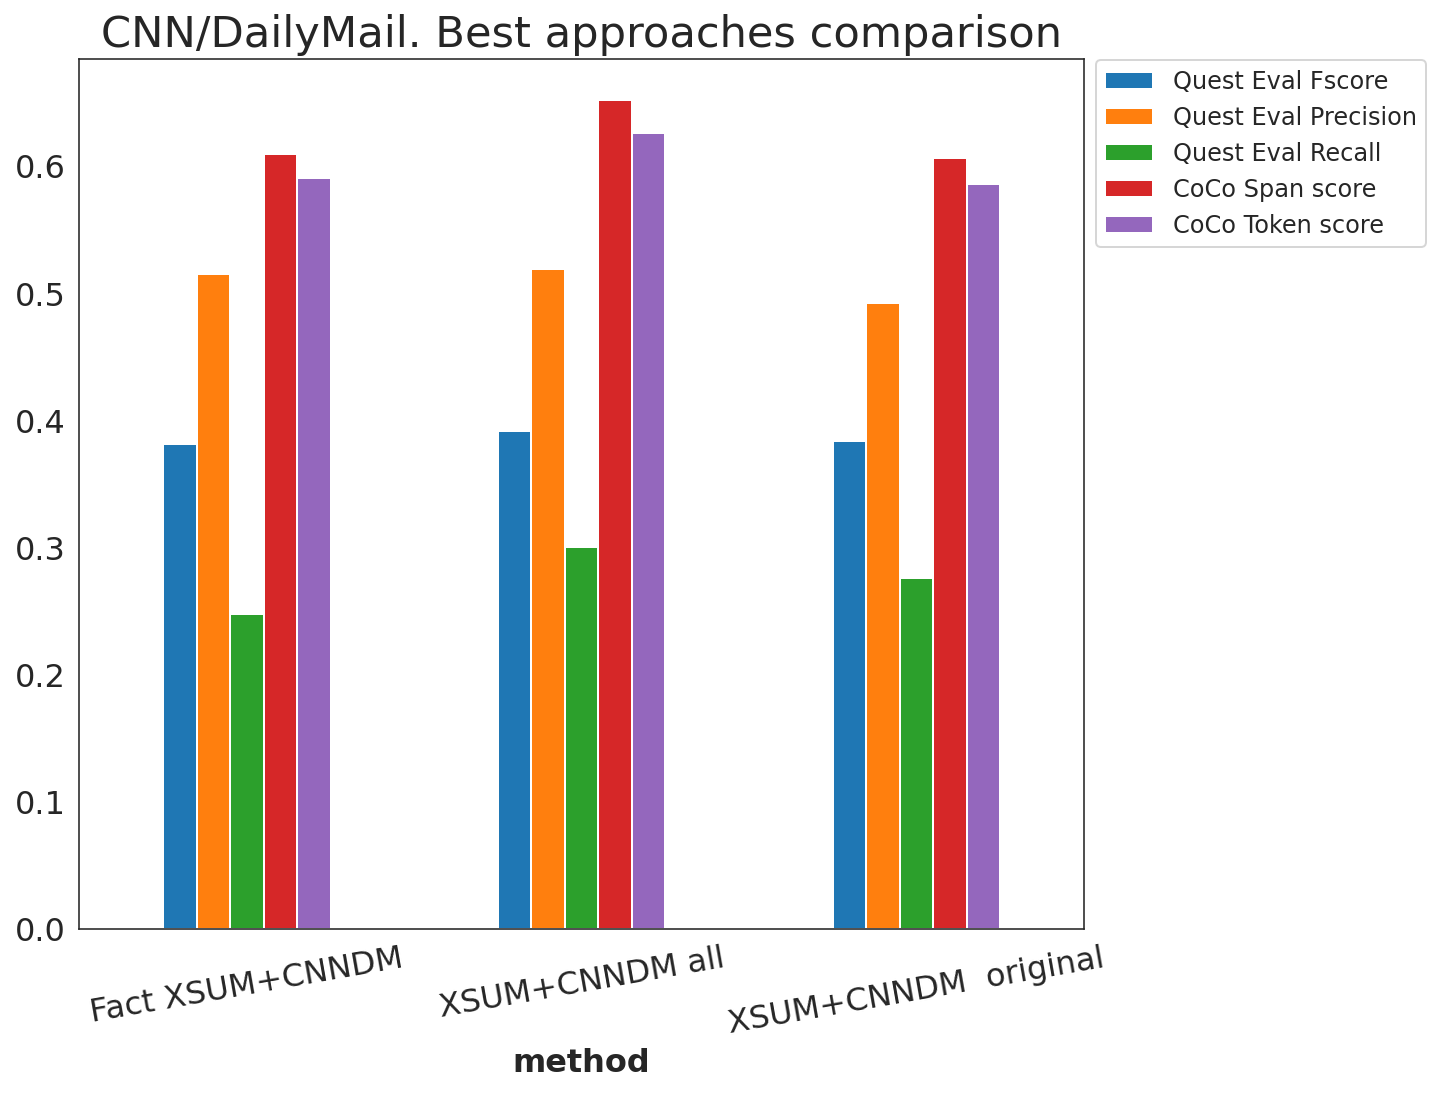

In [270]:
ax = plt.axes()
ax.set_title(f"CNN/DailyMail. Best approaches comparison")
ndf = df.iloc[[21, 23, 25]].reset_index()
ndf.plot(x="method", y=df.columns.values[:-3], kind="bar",figsize=(9,8), ax=ax)
ax.tick_params(axis='x', labelrotation = 10)
ax.legend(loc="lower left", bbox_to_anchor = (1.0, 0.77))